# Analyse des lieux de naissance


Les points à remarquer:
* la part importante prise par le nettoyage des données (le codage présuppose un modèle)
* les choix de la visualisation (le modèle produit par le logiciel de SIG)


Les Systèmes d'Information Géographique (SIG):
* [Système d'information géographique](https://fr.wikipedia.org/wiki/Syst%C3%A8me_d%27information_g%C3%A9ographique) (Wikipedia)
* [Qu'est-ce qu'un SIG ?](https://www.unil.ch/gis/home/menuinst/introduction/quest-ce-quun-sig.html) (UNIL)
* [Géoïde](https://fr.wikipedia.org/wiki/G%C3%A9o%C3%AFde) : la terre n'est pas sphérique
* [WGS84](https://fr.wikipedia.org/wiki/WGS_84) : le système de coordonnées géographiques actuellement uilisé

In [2]:
from SPARQLWrapper import SPARQLWrapper, SPARQLWrapper2, JSON, TURTLE, XML, RDFXML
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import pprint
import csv
import ast
import re

from collections import Counter
from operator import itemgetter

import sqlite3 as sql
import time

from importlib import reload
from shutil import copyfile

import math

In [4]:
### Instructions pour l'installation dans JupyterLab : 
# https://ipywidgets.readthedocs.io/en/latest/user_install.html#installing-in-jupyterlab-3-0
# Utiliser idéalement JupyterLab 3.0

from ipywidgets import (
    interact, IntSlider, Checkbox,
    interactive, SelectMultiple,
    SelectionRangeSlider, Layout,
    jslink, fixed,
    HTML, HBox)

In [5]:
from ipyleaflet import (Map,
                        Marker,
                        basemap_to_tiles,
                        basemaps,
                        CircleMarker,
                        MarkerCluster,
                        LayerGroup, 
                        LayersControl,
                        WidgetControl,
                        Popup,
                        ScaleControl
                       )

In [6]:
### Importer un module de fonctions crée ad hoc
## ATTENTION : le fichier 'sparql_functions.py' doit se trouver 
#   dans le même dossier que le présent carnet Jupyter afin que l'importation
#   fonctionne correctement
import sparql_functions as spqf

In [6]:
### Recharger le module après modification des fonctions dans le fichier du module
# désactivé #  
reload(spqf)

<module 'sparql_functions' from '/Volumes/Patientia/python_notebooks/sciences_historiques_numeriques/histoire_numerique/sparql/sparql_functions.py'>

## Base de données

In [6]:
### Définir les adresses des fichiers, l'existant et celui à créer
db = 'data/sparql_queries.db'

In [6]:
### Fonction qui récupère et met en forme le temps au moment de l'exécution

# définition
def timestamp_formatted_for_file_name():
    is_now = time.strftime('%Y%m%d_%H%M%S')
    return is_now

# exécution
timestamp_formatted_for_file_name()

'20210508_112546'

In [8]:
##  Noter que la différence de suffixe, en soi totalement arbitraire, 
#  dépend du fait que dans la configuration de .gitignore, .sqlite est exclu du verisonnement GIT
#  contrairement à .db qui est versionné
timestamped_db_copy = 'data/sparql_queries_' + timestamp_formatted_for_file_name() + '.sqlite'

In [9]:
### Créer une copie de sauvegarde avec timestamp du fichier (versionnement manuel)
# ATTENTION : la base de données doit exister à l'endroit indiqué !
## Cette requête n'est utile que si des modifications en écriture vont être apportées à la base de données,
# afint de préserver le dernier état avant modification

## Documentation:
# https://docs.python.org/3/library/shutil.htmlcopied_db = copyfile(original_db, timestamped_db_copy)

copied_db = copyfile(db, timestamped_db_copy)
copied_db

'data/sparql_queries_20210508_112559.sqlite'

# Explorer et coder les lieux de naissance


Préparation des données (cf. le carnet dbpedia_production):

* la requête 23 produit la liste des associations des économistes à leurs lieux de naissance (un ou plusieurs)
* la requête 26 liste ces mêmes lieux de naissance dans une logique DISTINCT, c'est-à-dire une seule ligne par lieu et ajoute ces lieux en tant qu'entités
* la requête 27 cherche les types de ces lieux de naissance afin de construire des filtres
  * malheureusement les données DBPedia ne sont pas très propres, des types significatifs manquent, cf. query_1 qui montre que des types manquent, valeur 'None'
  




## Requêtes préliminaires

* Inspecter, agréger, construire les données


In [7]:
### Définir les adresses des fichiers, l'existant et celui à créer
db = 'data/sparql_queries.db'

In [12]:
### Vérifier si tous les lieux on un type
query_1 ="""
SELECT e.uri_entity, p.value 
FROM entity e LEFT JOIN property p ON p.uri_entity = e.uri_entity 
WHERE e.entity_class = 'https://dbpedia.org/ontology/Place';
"""

In [22]:
### Combien de personnnes ont / n'ont pas un lieu de naissance renseigné : 3357 sur 6868 personnes ont un lieu de naissance
query_2 ="""
WITH TW1 AS (
SELECT DISTINCT  e.uri_entity 
FROM entity e 
  LEFT JOIN property p ON p.uri_entity = e.uri_entity AND property LIKE '%BirthPlace%'
WHERE e.entity_class = 'https://dbpedia.org/ontology/Person'
AND p.value IS NOT NULL --IS NULL;
)
SELECT COUNT (*)
FROM tw1;
"""

## Explorer les types de lieux de naissance

### Récupérer les données de la base de données

In [16]:
### Définir les adresses des fichiers, l'existant et celui à créer
db = 'data/sparql_queries.db'

In [17]:
### Liste des lieux avec types et coordonnées géographiques
lieux = """SELECT e.uri_entity, 
REPLACE(REPLACE(e.uri_entity, 'http://dbpedia.org/resource/', ''), '_', ' ') place_name, 
REPLACE(REPLACE(p.value, 'http://dbpedia.org/ontology/', ''), '_', ' ') place_type,
p1.value longitude, p2.value latitude
FROM entity e 
  LEFT JOIN property p ON p.uri_entity = e.uri_entity AND p.property LIKE '%type%'
  LEFT JOIN property p1 ON p1.uri_entity = e.uri_entity AND p1.property LIKE '%long'
  LEFT JOIN property p2 ON p2.uri_entity = e.uri_entity AND p2.property LIKE '%lat'
WHERE e.entity_class = 'https://dbpedia.org/ontology/Place'
--AND p.value IS NOT NULL   -- si décommmenté, élimine les lieux sans type
;"""

In [12]:
# connnexion à la base de données
cn = sql.connect(db)
c = cn.cursor()

### exécuter la requëte sur la base de donées SQLite pour récupérer les valeurs que contient la ligne
# attention au nom de la requête !
c.execute(lieux)
result_q = []
result_q = c.fetchall()

# fermer la connexion
cn.close()
print(len(result_q))
result_q[:4]

3179


[("http://dbpedia.org/resource/'s-Graveland",
  "'s-Graveland",
  'Village',
  '5.12111',
  '52.2442'),
 ('http://dbpedia.org/resource/A_Coruña',
  'A Coruña',
  'City',
  '-8.41',
  '43.365'),
 ('http://dbpedia.org/resource/Aalen', 'Aalen', 'Town', '10.1', '48.8333'),
 ('http://dbpedia.org/resource/Aalsmeer',
  'Aalsmeer',
  'Town',
  '4.75',
  '52.2667')]

### Types de lieux

On remarque ci-dessous la diversité des types et l'incohérence dans les données renseignant avec des types différentes des lieux similaires.

Cf. par ex. City et Town

In [13]:
### Requête 'lieux' !!! 
# transformée en DataFrame
df_lieux = pd.DataFrame(result_q, columns = ['uri', 'name', 'type', 'long', 'lat'])
df_lieux

,uri,name,type,long,lat
0,http://dbpedia.org/resource/'s-Graveland,'s-Graveland,Village,5.12111,52.2442
1,http://dbpedia.org/resource/A_Coruña,A Coruña,City,-8.41,43.365
2,http://dbpedia.org/resource/Aalen,Aalen,Town,10.1,48.8333
3,http://dbpedia.org/resource/Aalsmeer,Aalsmeer,Town,4.75,52.2667
4,"http://dbpedia.org/resource/Aba,_Hungary","Aba, Hungary",Town,18.5233,47.0307
...,...,...,...,...,...
3174,http://dbpedia.org/resource/Šiauliai,Šiauliai,City,23.3167,55.9333
3175,http://dbpedia.org/resource/Šibenik,Šibenik,City,15.9167,43.7333
3176,http://dbpedia.org/resource/Šilutė_District_Mu...,Šilutė District Municipality,Town,21.4833,55.35
3177,http://dbpedia.org/resource/Štip,Štip,None,22.1936,41.7375


In [14]:
### Regrouper par type de lieux et compter
gb_lieux = pd.DataFrame(df_lieux.groupby('type').size())
gb_lieux.columns = ['eff']
gb_lieux.sort_values(by='eff', ascending=False)

,eff
type,
City,820
Country,473
AdministrativeRegion,309
Region,277
Town,257
Village,98
CityDistrict,17
SoccerClub,12
Island,8


In [420]:
### Retrouper les types par lieux (plusieurs types pour un lieux) puis compter par groupe
# inspecter les différentes typologies : laquelle retenir ?
types_lieux = df_lieux.fillna(value='').groupby(['uri'])['type'].apply(','.join).reset_index()
gb_types_lieux = pd.DataFrame(types_lieux.groupby('type').size())
gb_types_lieux.columns = ['eff']
gb_types_lieux.sort_values(by='eff', ascending=False).head(10)

,eff
type,
,878
City,792
Country,395
Town,239
"AdministrativeRegion,Region",198
Village,90
"AdministrativeRegion,Country,Region",69
AdministrativeRegion,32
CityDistrict,15


## Obtenir un lieux par personne


Afin de pouvoir représenter les lieux de naissance sur une carte, avec les effectifs des personnes, il est indispensable de nettoyer préalablement les données et de ne disposer, après nettoyage, que d'un lieu généférencé de naissance par personne.

L'opération est assez délicate étant donné l'état incohérent des données produites automatiquement à partir de Wikipedia.



In [18]:
### Liste complete: personne, lieu, type, coordonnées géo
personnes_lieux_naissance = """
SELECT e.uri_entity, 
p4.value birth_year,
 REPLACE(REPLACE(p.value, 'http://dbpedia.org/resource/', ''), '_', ' ') place_name, 
REPLACE(p3.value, 'http://dbpedia.org/ontology/', '') place_type, 
p1.value longitude, p2.value latitude
FROM entity e 
  LEFT JOIN property p ON p.uri_entity = e.uri_entity AND p.property LIKE '%BirthPlace%'
  LEFT JOIN property p1 ON p1.uri_entity = p.value AND p1.property LIKE '%long'
  LEFT JOIN property p2 ON p2.uri_entity = p.value AND p2.property LIKE '%lat'
  LEFT JOIN property p3 ON p3.uri_entity = p.value AND p3.property LIKE '%type%'
  LEFT JOIN property p4 ON p4.uri_entity = e.uri_entity AND p4.property LIKE '%irthYe%' AND p4."source" LIKE '%8 mai 2021%'
WHERE e.entity_class = 'https://dbpedia.org/ontology/Person'
AND longitude IS NOT NULL;
"""

In [19]:
### Créer un DataFrame directement à partir d'une requête
# Attention : requête-query 'personnes_lieux_naissance', cf. ci-dessus !

cn = sql.connect(db)
lieux_naissance = pd.read_sql_query(personnes_lieux_naissance, cn).fillna(value='')
cn.close()
lieux_naissance.head()

,uri_entity,birth_year,place_name,place_type,longitude,latitude
0,http://dbpedia.org/resource/A._C._Cuza,1857,Iași,AdministrativeRegion,27.5903,47.1569
1,http://dbpedia.org/resource/A._C._Cuza,1857,Iași,Region,27.5903,47.1569
2,http://dbpedia.org/resource/A._K._Shiva_Kumar,1956,Chennai,City,80.275,13.0827
3,http://dbpedia.org/resource/A._K._Shiva_Kumar,1956,India,Country,77.2083,28.6139
4,http://dbpedia.org/resource/A._K._Shiva_Kumar,1956,Tamil Nadu,,80.27,13.09


In [64]:
### Construire une colonne qui contient les propriétés des lieux regroupées sous forme de liste

## Avec cette astuce on regroupe toutes les propriétés de chaque lieux dans une liste propre à chaque lieu (cf. la suite ci-dessous)

lieux_naissance['place_list'] = lieux_naissance[['place_name','place_type','longitude','latitude']].apply(lambda x: list(x), axis=1)
lieux_naissance.head()

,uri_entity,birth_year,place_name,place_type,longitude,latitude,place_list
0,http://dbpedia.org/resource/A._C._Cuza,1857,Iași,AdministrativeRegion,27.5903,47.1569,"[Iași, AdministrativeRegion, 27.5903, 47.1569]"
1,http://dbpedia.org/resource/A._C._Cuza,1857,Iași,Region,27.5903,47.1569,"[Iași, Region, 27.5903, 47.1569]"
2,http://dbpedia.org/resource/A._K._Shiva_Kumar,1956,Chennai,City,80.275,13.0827,"[Chennai, City, 80.275, 13.0827]"
3,http://dbpedia.org/resource/A._K._Shiva_Kumar,1956,India,Country,77.2083,28.6139,"[India, Country, 77.2083, 28.6139]"
4,http://dbpedia.org/resource/A._K._Shiva_Kumar,1956,Tamil Nadu,,80.27,13.09,"[Tamil Nadu, , 80.27, 13.09]"


In [65]:
### Ensuite, on regroupe les lieux de naissance (les listes des propriétés des lieux) par personne et produire un nouveau dataframe

## Tous les lieux sous forme de liste produits à la cellule précédente seront ainsi réunis

l_lieux_naissance = lieux_naissance.groupby(['uri_entity']).agg({'place_list': lambda x: list(x),'birth_year': lambda x: max(x)}).reset_index()
l_lieux_naissance.head()

,uri_entity,place_list,birth_year
0,http://dbpedia.org/resource/A._C._Cuza,"[[Iași, AdministrativeRegion, 27.5903, 47.1569...",1857
1,http://dbpedia.org/resource/A._K._Shiva_Kumar,"[[Chennai, City, 80.275, 13.0827], [India, Cou...",1956
2,http://dbpedia.org/resource/Aaron_Director,"[[Staryi Chortoryisk, Village, 25.8825, 51.224...",1901
3,http://dbpedia.org/resource/Aat_van_Rhijn,"[[Groningen, City, 6.56667, 53.2167], [Netherl...",1892
4,http://dbpedia.org/resource/Abass_Bundu,"[[Gbinti, , -12.6, 8.96667], [Port Loko Distri...",1948


In [66]:
### Eliminer les lieux multiples pour une personne en privilégiant les villes et
#   autres lieux habités par rapport aux territoires

## Avec un boucle 'for' on parcourt dans l'ordre les types significatifs
# si la variable 'i_lieux_naiss' est remplie avec un lieu, sa longueur ne sera plus 0 et donc on sort de la boucle
# sinon on prend le prochain lieu de naissance de cette personne, de n'importe quel type

lieux_naissance_unique = []
for l in l_lieux_naissance.to_records():
    
    i_lieux_naiss = []
    if len(i_lieux_naiss) == 0:
        for i in l[2]:
            if i[1] == 'Village':
                i_lieux_naiss = i
            elif i[1] == 'City':
                i_lieux_naiss = i
            elif i[1] == 'Town':
                i_lieux_naiss = i
            elif i[1] == 'Island':
                i_lieux_naiss = i
    else:
        pass
    if len(i_lieux_naiss) == 0:
        i_lieux_naiss = l[2][0]
    ##  la valeur 2000 est pour les personnes sans date de naissance
    lieux_naissance_unique.append([l[1]] + i_lieux_naiss + [int(l[3]) if str(l[3]) > '' else 2000])


print(len(lieux_naissance_unique))
lieux_naissance_unique[:2]

3091


[['http://dbpedia.org/resource/A._C._Cuza',
  'Iași',
  'AdministrativeRegion',
  '27.5903',
  '47.1569',
  1857],
 ['http://dbpedia.org/resource/A._K._Shiva_Kumar',
  'Chennai',
  'City',
  '80.275',
  '13.0827',
  1956]]

In [67]:
### Ajouter une colonne avec les noms de personne et limiter aux personnes nées après 1770

df_lnu = pd.DataFrame(lieux_naissance_unique)
print(len(df_lnu))
df_lnu.columns = ['uri_entity','place_name','place_type','long','lat', 'birth_year']
df_lnu['person'] = df_lnu['uri_entity'].apply(lambda x : x.replace('http://dbpedia.org/resource/', '').replace('_',' ')) 
df_lnu = df_lnu[df_lnu['birth_year'] > 1770]
print(len(df_lnu))

3091
3035


In [68]:
### Vérifier s'il y a bien un lieu de naissance par personne
gb_df_lnu = df_lnu.groupby(['uri_entity']).size()
print("Plus d'un lieux : " + str(len(gb_df_lnu[gb_df_lnu > 1])))
print("Aucun lieux : " + str(len(gb_df_lnu[gb_df_lnu == 0])))
print("Personnes avec un lieu de naissance : " + str(len(gb_df_lnu[gb_df_lnu == 1])))
df_lnu.head()

Plus d'un lieux : 0
Aucun lieux : 0
Personnes avec un lieu de naissance : 3035


,uri_entity,place_name,place_type,long,lat,birth_year,person
0,http://dbpedia.org/resource/A._C._Cuza,Iași,AdministrativeRegion,27.5903,47.1569,1857,A. C. Cuza
1,http://dbpedia.org/resource/A._K._Shiva_Kumar,Chennai,City,80.275,13.0827,1956,A. K. Shiva Kumar
2,http://dbpedia.org/resource/Aaron_Director,Staryi Chortoryisk,Village,25.8825,51.2242,1901,Aaron Director
3,http://dbpedia.org/resource/Aat_van_Rhijn,Groningen,City,6.56667,53.2167,1892,Aat van Rhijn
4,http://dbpedia.org/resource/Abass_Bundu,Gbinti,,-12.6,8.96667,1948,Abass Bundu


### Inspecter la distribution des naissances dans le temps

[1771, 1772, 1773, 1774, 1775]


<BarContainer object of 203 artists>

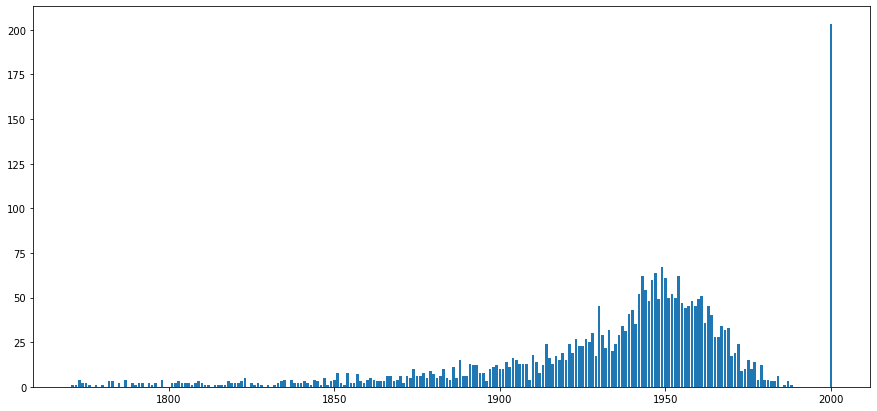

In [69]:
### Distribution des naissances dans le temps. Pour mémoire : 2000 = sans année de naissance

## Noter : le regroupement est effectué par année


gb_annees_naiss = df_lnu.groupby(['birth_year']).size()


objects = [l for l in gb_annees_naiss.index]
eff = [l for l in gb_annees_naiss]

print(objects[:5])
plt.figure(figsize=(15,7))
plt.bar(objects, eff)

## Produire les données à projeter sur une carte

### Ajouter les périodes d'activité

On aimerait découper en période d'activité correspondantes au moments de l'histoire Européenne, puis mondiale.

Périodes d'activités: -1900 (avant le 20e siècle), 1901-1945 (la période des guerres mondiales), 1946- (l'époque contemporaine)

À défaut de dates plus précises, on imagines ces bornes pour la période d'activité des personnes:
* min: naissance + 25 ans
* max: naissance + 75 ans


In [138]:
### Fonction qui effectue le classement

# plusieurs périodes d'activité sont possibles pour une même personne

def periode_activite(birth_year):    
    valeur_periode = []
    if (birth_year + 25) < 1901:
        valeur_periode.append("-1900")        
    # la deuxième clause exclut les personnes qui ne sont vraisemblablement plus actives
    # bien que nées avant la date indiquée
    if (birth_year + 75) > 1900 and (birth_year + 25) < 1946:
        valeur_periode.append("1901-1945")
    if (birth_year + 75) > 1945:
        valeur_periode.append("1946-")
    return valeur_periode    

In [148]:
periode_activite(1860), periode_activite(1873), periode_activite(1900)

(['-1900', '1901-1945'],
 ['-1900', '1901-1945', '1946-'],
 ['1901-1945', '1946-'])

In [149]:
### Ajouter les périodes d'activité à l'aide de la fonction : periode_activite

df_lnu['periode_activite'] = df_lnu['birth_year'].apply (lambda x : periode_activite(x) ) 

In [150]:
### Préparer les données qui seront utilisées dans le popup de la carte
# construire une colonne qui contient (avec séparateur pipe, '|', uri, nom et année de naissance)

df_lnu['concat_person'] = df_lnu['uri_entity'] + '|' + df_lnu['person'] + df_lnu['birth_year'].apply (lambda x : ' (' + str(x) + ')' ) 

In [211]:
df_lnu.head()

,uri_entity,place_name,place_type,long,lat,birth_year,person,concat_person,periode_activite
0,http://dbpedia.org/resource/A._C._Cuza,Iași,AdministrativeRegion,27.5903,47.1569,1857,A. C. Cuza,http://dbpedia.org/resource/A._C._Cuza|A. C. C...,"[-1900, 1901-1945]"
1,http://dbpedia.org/resource/A._K._Shiva_Kumar,Chennai,City,80.275,13.0827,1956,A. K. Shiva Kumar,http://dbpedia.org/resource/A._K._Shiva_Kumar|...,[1946-]
2,http://dbpedia.org/resource/Aaron_Director,Staryi Chortoryisk,Village,25.8825,51.2242,1901,Aaron Director,http://dbpedia.org/resource/Aaron_Director|Aar...,"[1901-1945, 1946-]"
3,http://dbpedia.org/resource/Aat_van_Rhijn,Groningen,City,6.56667,53.2167,1892,Aat van Rhijn,http://dbpedia.org/resource/Aat_van_Rhijn|Aat ...,"[1901-1945, 1946-]"
4,http://dbpedia.org/resource/Abass_Bundu,Gbinti,,-12.6,8.96667,1948,Abass Bundu,http://dbpedia.org/resource/Abass_Bundu|Abass ...,[1946-]


In [312]:
### Regrouper par lieu
# https://izziswift.com/naming-returned-columns-in-pandas-aggregate-function/
place_count = df_lnu.groupby(['place_name', 'place_type', 'long', 'lat'], as_index=False) \
      .agg(persons = ('concat_person', ','.join), effectif=('person', 'count'),\
       periodes = ('periode_activite', 'sum')).sort_values(by=['place_name'])
print(len(place_count))
place_count[130:135]

1663


,place_name,place_type,long,lat,persons,effectif,periodes
130,"Bayonne, New Jersey",City,-74.1102,40.6625,http://dbpedia.org/resource/Faye_Duchin|Faye D...,2,"[1946-, 1946-]"
131,"Beatrice, Nebraska",City,-96.7431,40.2683,http://dbpedia.org/resource/Harold_Thayer_Davi...,1,"[1901-1945, 1946-]"
132,"Beaumont, Texas",City,-94.1267,30.08,http://dbpedia.org/resource/John_Graham_(econo...,1,[1946-]
133,"Beckley, West Virginia",City,-81.1881,37.7781,http://dbpedia.org/resource/Tom_Carper|Tom Car...,1,[1946-]
134,Bedfordshire,AdministrativeRegion,-0.416667,52.0833,http://dbpedia.org/resource/Andrew_Stuart_Winc...,1,[1946-]


In [315]:
### Agrège et compte les périodes 
# NB Une personnes pouvant être dans plusieurs périodes, la somme des effectifs des périodes peut-être plus élevée que celle de l'effectif total
place_count['periodes_agregees'] = place_count['periodes'].apply(lambda x : dict(Counter(x)))

In [316]:
### Un exemples : Londres 
place_count[place_count['place_name'] == 'London']

,place_name,place_type,long,lat,persons,effectif,periodes,periodes_agregees
899,London,City,-0.1275,51.5072,http://dbpedia.org/resource/Alan_Budd|Alan Bud...,26,"[1946-, 1946-, -1900, 1901-1945, 1946-, 1901-1...","{'1946-': 23, '-1900': 3, '1901-1945': 6}"


In [317]:
place_count[place_count['place_name'] == 'London']['periodes_agregees'].values[0]

{'1946-': 23, '-1900': 3, '1901-1945': 6}

### Ecrire les données à cartographier dans un fichier CSV

Le fichier 'maps/birth_place_years.csv' contiendra les données à cartographier et il ne sera pas nécessaire de refaire chaque fois les manipulations ci-dessus, mais on pourra directement travailler sur les cartes

In [318]:
place_count.to_csv('maps/birth_place_years.csv', sep=';')

In [ ]:
### Importer le CSV et mettre son contenu dans la variable 'place_count' 
# au cas où on ne souhaite pas répéter toutes les opérations précédentes
place_count = pd.read_csv('maps/birth_place_years.csv', sep=';', index_col=[0])
place_count.iloc[100:110]

## Universités

On prépare ici les données concernant les universités fréquentées. 

* Dans DBPedia les Universités sont souvent associées à un lieu. 
* On utilise ici le lieu (si disponible) pour géoréférencer les Universités. 
* Pour les Universités sans coordonnées géographiques on pourrait chercher celles du lieu où une Université a son siège
* Ce serait trop laborieux dans ce contexte, sachant que une Université peut avoir plusieurs sièges, éventuellement changeant dans le temps
* Cette requête est donc effectuée uniquement à titre d'exemple

In [202]:
universites = """
SELECT
	p.uri_entity,
	p.value birth_year,
	REPLACE(REPLACE(p1.value,
	'http://dbpedia.org/resource/',
	''),
	'_',
	' ') university_name,
	p2.value long,
	p3.value lat
FROM
	property p
JOIN property p1 ON
	p.uri_entity = p1.uri_entity
	AND p1.property LIKE '%almaMater'
LEFT JOIN property p2 ON
	p2.uri_entity = p1.value
	AND p2.property LIKE '%long'
LEFT JOIN property p3 ON
	p3.uri_entity = p1.value
	AND p3.property LIKE '%lat'
WHERE
	p.property LIKE '%birthYear'
	AND p."source" LIKE '%8 mai 2021';"""

In [204]:
cn = sql.connect(db)
personnes_universites = pd.read_sql_query(universites, cn).fillna(value='')
cn.close()
personnes_universites.head()

,uri_entity,birth_year,university_name,long,lat
0,http://dbpedia.org/resource/A._D._Roy,1920,University of Cambridge,0.117222,52.2053
1,http://dbpedia.org/resource/A._K._Shiva_Kumar,1956,Bangalore University,77.5032,12.9388
2,http://dbpedia.org/resource/A._K._Shiva_Kumar,1956,Harvard University,-71.1169,42.3744
3,http://dbpedia.org/resource/A._K._Shiva_Kumar,1956,IIM Ahmedabad,,
4,http://dbpedia.org/resource/A._K._Shiva_Kumar,1956,"St. Joseph's College, Bangalore",77.5964,12.9629


In [205]:
gp_years = personnes_universites.groupby('birth_year').size()
gp_years.sort_values(ascending=False)

birth_year
1943    114
1949    112
1946    102
1953    102
1951    100
       ... 
1830      1
1826      1
1815      1
1810      1
1460      1
Length: 180, dtype: int64

In [215]:
### Personnes avec (3259) / sans (976) coordonnées géographiques
len(personnes_universites[personnes_universites['long'] == '']) # ['long'] > ''

976

In [216]:
### Personnes avec (4235) / sans (0) annee naissance
len(personnes_universites[personnes_universites['birth_year'] > '']) # ['birth_year'] == ''

4235

In [217]:
## construire un découpage qui peut avoir du sens par rapport à la situation historique
cut_years = [1771, 1861, 1901, 1921, 1941, 1951, 1961, 1971, 2001]

In [218]:
## Transformer l'année de naissance en entier
personnes_universites['birth_year'] = personnes_universites['birth_year'].apply(lambda x : int(x))

## sélection de valeurs sur plusieurs colonnes
personnes_uni_1771 = personnes_universites[(personnes_universites['birth_year'] > 1770) & (personnes_universites['long'] != '')]
personnes_uni_1771 = personnes_uni_1771.copy(deep=True)

In [219]:
## Compter les années de naissance

personnes_uni_1771.groupby('birth_year').size().sort_values(ascending=False)

birth_year
1943    90
1958    83
1953    82
1949    81
1951    81
        ..
1846     1
1863     1
1849     1
1858     1
1771     1
Length: 168, dtype: int64

In [221]:
### coder les années les regroupant par périodes : fonction cut

personnes_uni_1771['periode'] = pd.cut(personnes_uni_1771['birth_year'], cut_years, right=False)
### Rendre les périodes plus lisibles
personnes_uni_1771['periode'] = personnes_uni_1771['periode'].apply(lambda row : str(int(row.left))+'-'+str(int(row.right)))
personnes_uni_1771.head()

,uri_entity,birth_year,university_name,long,lat,periode
0,http://dbpedia.org/resource/A._D._Roy,1920,University of Cambridge,0.117222,52.2053,1901-1921
1,http://dbpedia.org/resource/A._K._Shiva_Kumar,1956,Bangalore University,77.5032,12.9388,1951-1961
2,http://dbpedia.org/resource/A._K._Shiva_Kumar,1956,Harvard University,-71.1169,42.3744,1951-1961
4,http://dbpedia.org/resource/A._K._Shiva_Kumar,1956,"St. Joseph's College, Bangalore",77.5964,12.9629,1951-1961
6,http://dbpedia.org/resource/Aaron_Director,1901,Yale University,-72.9267,41.3111,1901-1921


In [222]:
### vérifier le codage – pas de lacunes
personnes_uni_1771[personnes_uni_1771['periode'].isnull()==True]

,uri_entity,birth_year,university_name,long,lat,periode


In [223]:
### Regrouper par periode et compter avec la fonction Pandas 'groupby'
gb_periode = personnes_uni_1771.groupby('periode').size()
gb_periode

periode
1771-1861     76
1861-1901    194
1901-1921    252
1921-1941    671
1941-1951    730
1951-1961    683
1961-1971    474
1971-2001    172
dtype: int64

In [224]:
## Créer la liste des périodes
liste_periodes = gb_periode.index.tolist()
liste_periodes

['1771-1861',
 '1861-1901',
 '1901-1921',
 '1921-1941',
 '1941-1951',
 '1951-1961',
 '1961-1971',
 '1971-2001']

['1771-1861', '1861-1901', '1901-1921', '1921-1941', '1941-1951']


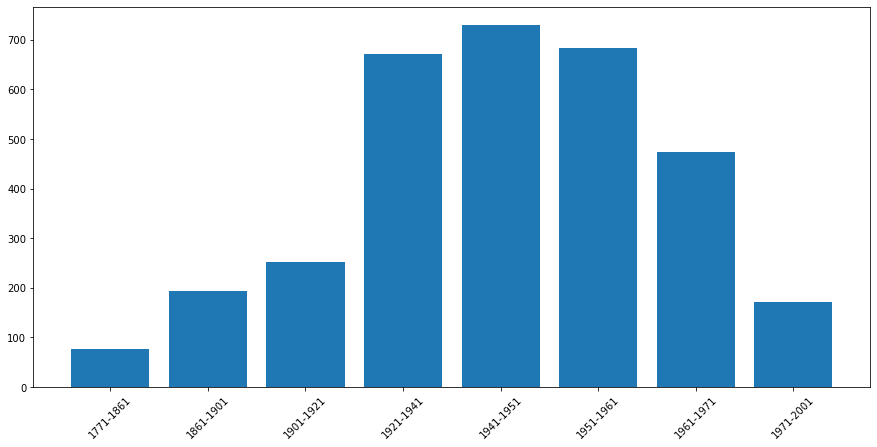

In [227]:
### Distribution des naissances par période

objects = [l for l in gb_periode.index]
eff = [l for l in gb_periode]

print(objects[:5])
plt.figure(figsize=(15,7))
plt.xticks(rotation=45)
a = plt.bar(objects, eff)

In [228]:
personnes_universites.head()

,uri_entity,birth_year,university_name,long,lat
0,http://dbpedia.org/resource/A._D._Roy,1920,University of Cambridge,0.117222,52.2053
1,http://dbpedia.org/resource/A._K._Shiva_Kumar,1956,Bangalore University,77.5032,12.9388
2,http://dbpedia.org/resource/A._K._Shiva_Kumar,1956,Harvard University,-71.1169,42.3744
3,http://dbpedia.org/resource/A._K._Shiva_Kumar,1956,IIM Ahmedabad,,
4,http://dbpedia.org/resource/A._K._Shiva_Kumar,1956,"St. Joseph's College, Bangalore",77.5964,12.9629


In [229]:
personnes_uni_1771.loc[:0,'periode']

0    1901-1921
Name: periode, dtype: category
Categories (8, object): ['1771-1861' < '1861-1901' < '1901-1921' < '1921-1941' < '1941-1951' < '1951-1961' < '1961-1971' < '1971-2001']

In [231]:
### Periode est une 'category', elle est transformée ici en une chaine de caractères, 
#  ce qui est nécessaire pour le regroupement ci-dessous
personnes_uni_1771['periode'] = personnes_uni_1771['periode'].astype(str)

In [232]:
personnes_uni_1771.loc[:0,'periode']

0    1901-1921
Name: periode, dtype: object

In [233]:
personnes_uni_1771[personnes_uni_1771['university_name'] == 'Aarhus University']

,uri_entity,birth_year,university_name,long,lat,periode
223,http://dbpedia.org/resource/Anders_Fogh_Rasmussen,1953,Aarhus University,10.2011,56.1706,1951-1961
3874,http://dbpedia.org/resource/Tim_Bollerslev,1958,Aarhus University,10.2011,56.1706,1951-1961


### Données à cartographier concernant les Universités

In [234]:
## Compter les personnes par université et période
gb_periode_uni = personnes_uni_1771.groupby(['university_name','long','lat', 'periode']).agg({'birth_year': 'count'}).reset_index()
gb_periode_uni = gb_periode_uni.rename(columns={'birth_year': 'effectif'})
gb_periode_uni.head()

,university_name,long,lat,periode,effectif
0,Aarhus University,10.2011,56.1706,1951-1961,2
1,Aberystwyth University,-4.06576,52.4181,1921-1941,1
2,Achimota School,-0.213611,5.62722,1921-1941,1
3,Adelphi University,-73.652,40.72,1961-1971,1
4,Ahmadu Bello University,7.7,11.0667,1941-1951,1


#### Ecrire les données à cartographier dans un fichier CSV

Le fichier 'maps/birth_place_almaMater.csv' contiendra les données à cartographier concernant les Universités et il ne sera plus nécessaire de refaire les manipulations ci-dessus, mais on pourra directement travailler sur les cartes après avoir réimporté ce fichier

In [235]:
gb_periode_uni.to_csv('maps/birth_place_almaMater.csv', sep=';')

In [236]:
### Importer le CSV et mettre son contenu dans la variable 'place_count' 
# au cas où on ne souhaite pas répéter toutes les opérations précédentes
gb_periode_uni = pd.read_csv('maps/birth_place_almaMater.csv', sep=';', index_col=[0])
gb_periode_uni.head()

,university_name,long,lat,periode,effectif
0,Aarhus University,10.201100,56.17060,1951-1961,2
1,Aberystwyth University,-4.065760,52.41810,1921-1941,1
2,Achimota School,-0.213611,5.62722,1921-1941,1
3,Adelphi University,-73.652000,40.72000,1961-1971,1
4,Ahmadu Bello University,7.700000,11.06670,1941-1951,1


# Créer une carte



Nous utilisons ici la librairie __[ipyleaflet](https://ipyleaflet.readthedocs.io/en/latest/): Interactive maps in the Jupyter notebook__
* Installation : [JupyterLab extension](https://ipyleaflet.readthedocs.io/en/latest/installation.html#jupyterlab-extension)


D'autres librairies existent telles que Folium, [GeoPandas](https://geopandas.org/), etc.



Voir le tutoriel de [Programming Historian](https://programminghistorian.org/en/lessons/mapping-with-python-leaflet) à ce sujet

## Choisir d'abord un fonds de carte adapté

* Noter qu'on peut activer ou désactiver les fonds de carte dans le contrôle ne haut à droite 
* On peut ainsi les compater et choisir le plus adapté en fonction des données à afficher

In [321]:
## trois exemples sont proposés ici, bien d'autres existent

watercolor = basemap_to_tiles(basemaps.Stamen.Watercolor)
esri_sat = basemap_to_tiles(basemaps.Esri.WorldImagery)
open_street_map = basemap_to_tiles(basemaps.OpenStreetMap.Mapnik)

## https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20Styling.html
m1 = Map(layers=(watercolor,esri_sat,open_street_map), center=(35, 5), layout=Layout(width='100%', height='600px'),\
        zoom_control=True  , zoom=4 #, scroll_wheel_zoom=True
       )

control = LayersControl(name='layCont', position='topright')
m1.add_control(control)

m1.add_control(ScaleControl(position='topleft'))

m1



Map(center=[35, 5], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

## Carte avec valeurs agrégées : fonds de carte

In [322]:
# Chois du fonds de carte:
open_street_map = basemap_to_tiles(basemaps.OpenStreetMap.Mapnik)

## https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20Styling.html
m1 = Map(layers=(open_street_map,), center=(35, 5), layout=Layout(width='100%', height='600px'),\
        zoom_control=False    # , zoom=4, scroll_wheel_zoom= True
       )

zoom_slider = IntSlider(description='Zoom level:', min=0, max=15, value=2)
jslink((zoom_slider, 'value'), (m1, 'zoom'))
widget_control1 = WidgetControl(widget=zoom_slider, position='bottomright')
m1.add_control(widget_control1)

control = LayersControl(name='layCont', position='topright')
m1.add_control(control)

m1.add_control(ScaleControl(position='topleft'))

m1



Map(center=[35, 5], controls=(AttributionControl(options=['position', 'prefix'], position='bottomright'), Widg…

## Ajouter la couche avec les personnes

Noter que le calcul de l'affichage peut prendre quelques secondes en fonction du nombre de points à projeter sur la carte

In [323]:
place_count[130:135]

,place_name,place_type,long,lat,persons,effectif,periodes,periodes_agregees
130,"Bayonne, New Jersey",City,-74.110200,40.6625,http://dbpedia.org/resource/Faye_Duchin|Faye D...,2,"['1946-', '1946-']",{'1946-': 2}
131,"Beatrice, Nebraska",City,-96.743100,40.2683,http://dbpedia.org/resource/Harold_Thayer_Davi...,1,"['1901-1945', '1946-']","{'1901-1945': 1, '1946-': 1}"
132,"Beaumont, Texas",City,-94.126700,30.0800,http://dbpedia.org/resource/John_Graham_(econo...,1,['1946-'],{'1946-': 1}
133,"Beckley, West Virginia",City,-81.188100,37.7781,http://dbpedia.org/resource/Tom_Carper|Tom Car...,1,['1946-'],{'1946-': 1}
134,Bedfordshire,AdministrativeRegion,-0.416667,52.0833,http://dbpedia.org/resource/Andrew_Stuart_Winc...,1,['1946-'],{'1946-': 1}


In [324]:
## Parcourir le DataFrame et extraire les valeurs
#  i = index, v = valeur

markers = []
for i,v in place_count.iterrows():
    circle = CircleMarker(location=(v['lat'], v['long']), color="black", name=f"{v['place_name']}", \
                              radius = v['effectif']+2, weight=1)   
    
    markers.append(circle)


print("Markers' number " + str(len(markers)))

### Le MarkerCluster agrège automatiquement les résultats en fonction de l'échelle 
# alors que le LayerGroup affiche toujours tout, indépendamment du facteur de zoom

# lg1 = LayerGroup(name='Birth places ' + name_part, layers=(markers))
lg1 = MarkerCluster(name='Birth places', markers=markers)

m1.add_layer(lg1)

Markers' number 1663


### Ajouter la couche avec les Universités

In [325]:
## Compter les personnes par université et période
gb_count_uni = personnes_uni_1771.groupby(['university_name','long','lat']).agg({'birth_year': 'count'}).reset_index()
gb_count_uni = gb_count_uni.rename(columns={'birth_year': 'effectif'})
gb_count_uni.head()

,university_name,long,lat,effectif
0,Aarhus University,10.2011,56.1706,2
1,Aberystwyth University,-4.06576,52.4181,1
2,Achimota School,-0.213611,5.62722,1
3,Adelphi University,-73.652,40.72,1
4,Ahmadu Bello University,7.7,11.0667,1


In [326]:
## Parcourir le DataFrame et extraire les valeurs
#  i = index, v = valeur

markers = []
for i,v in gb_count_uni.iterrows():
    marker = Marker(location=(v['lat'], v['long']), draggable=False,\
                    title=  v['university_name'] + ' (' + str(v['effectif']) + ')' )
                    
    
    markers.append(marker)


print("Markers' number " + str(len(markers)))

lg2 = MarkerCluster(name='Universities', markers=markers)

m1.add_layer(lg2)

Markers' number 813


### Enregistrer et afficher la carte au format HTML

* Noter que la partie interactive ne marche – l'enregistrement ne s'applique qu'aux parties de la carte statiques, à l'état du moment de l'enregistrement
* Ouvrir le nouveau ficher de la carte directement dans un navigateur web, en le cherchant et ouvrant depuis le navigateur
* Noter que l'affichage de la carte dans le navigateur peut prendre quelques secondes en fonction du poids du fichier de la carte

In [327]:
m1.save('maps/birth_place_almaMater.html', title='Birth places and universities')

### Ajouter les couches des Universités par tranches chronologiques


Cette requête avancée illustre la possibilité de créer automatiquement une série de couches sur une carte

* En décochant toutes les couches dans le contrôle des couches, puis on les recochant on peut explorer le changement dans le temps de la distribution dans l'espace des naissances
* Noter que les nouvelles couches sont projetées sur la carte ci-dessus

In [248]:
gb_periode_uni

,university_name,long,lat,periode,effectif
0,Aarhus University,10.201100,56.17060,1951-1961,2
1,Aberystwyth University,-4.065760,52.41810,1921-1941,1
2,Achimota School,-0.213611,5.62722,1921-1941,1
3,Adelphi University,-73.652000,40.72000,1961-1971,1
4,Ahmadu Bello University,7.700000,11.06670,1941-1951,1
...,...,...,...,...,...
1580,École nationale d'administration,7.737220,48.58060,1951-1961,1
1581,École nationale de l'aviation civile,1.481110,43.56530,1921-1941,2
1582,École normale supérieure Paris-Saclay,2.326630,48.78870,1971-2001,1
1583,École pratique des hautes études,2.340000,48.83110,1901-1921,1


In [249]:
len(liste_periodes)

8

In [251]:
### Créer une liste de couleurs pour l'affichage
import matplotlib.colors as mcolors
col_list = [c for c in mcolors.TABLEAU_COLORS.values()]
col_list[:3]

['#1f77b4', '#ff7f0e', '#2ca02c']

In [253]:
### créer des variables dynamiques, le nom de la variable (créé préalablement) est appelé par l'index

# un exemple

layers_ids = ['lg' + str(x) for x in range(len(liste_periodes))]
my_dict = {}
for x in range(len(liste_periodes)):
    my_dict[x] = layers_ids[x]

my_dict[0]

'lg0'

In [254]:
idx = 0
for p in liste_periodes:    
    markers = []
    print(p)
    for i,v in gb_periode_uni.iterrows():
        if p == v['periode']:
            circle = CircleMarker(location=(v['lat'], v['long']), color=col_list[idx], name=f"{v['university_name']}", \
                              radius = int(math.log((v['effectif'] + 1) * 3, 2)), weight=1)
            # message.value = f"<h4>{j['place_name']} ({j['count_persons']})</h4>" + p_elements
            # a = HBox([message], layout=Layout(width='200px', height='200px', overflow_y='auto',overflow="auto"))
            message = HTML()
            message.value = f"{v['university_name']} ({v['effectif']})"

            a = HBox([message], layout=Layout(width='100px', height='200px', overflow="auto")) # overflow_y='auto',

            circle.popup = a
        
            markers.append(circle)


    print("Markers' number " + str(len(markers)))

    # lg = MarkerCluster(name='Universités (' + v['periode'] +')', markers=markers)
    my_dict[idx] = LayerGroup(name='Universités (' + p +')', layers=(markers))
    
    m1.add_layer(my_dict[idx])
    idx += 1

1771-1861
Markers' number 49
1861-1901
Markers' number 98
1901-1921
Markers' number 128
1921-1941
Markers' number 265
1941-1951
Markers' number 332
1951-1961
Markers' number 322
1961-1971
Markers' number 265
1971-2001
Markers' number 126


In [329]:
place_count.iloc[102:108]

,place_name,place_type,long,lat,persons,effectif,periodes,periodes_agregees
102,Balatina,Village,27.35000,47.7000,http://dbpedia.org/resource/Anatol_Stati|Anato...,1,['1946-'],{'1946-': 1}
103,Balatonlelle,Town,17.67570,46.7822,http://dbpedia.org/resource/István_Kossa|Istvá...,1,"['1901-1945', '1946-']","{'1901-1945': 1, '1946-': 1}"
104,Balingen,Town,8.85056,48.2731,http://dbpedia.org/resource/Gerd_Hahn|Gerd Hah...,1,['1946-'],{'1946-': 1}
105,"Ballston, New York",Town,-73.87470,42.9533,http://dbpedia.org/resource/Sidney_Sherwood|Si...,1,"['-1900', '1901-1945']","{'-1900': 1, '1901-1945': 1}"
106,Baltimore,City,-76.61530,39.2894,http://dbpedia.org/resource/Ansley_J._Coale|An...,4,"['1901-1945', '1946-', '1901-1945', '1946-', '...","{'1901-1945': 3, '1946-': 4}"
107,Bandung,City,107.61000,-6.9120,http://dbpedia.org/resource/Faisal_Basri|Faisa...,1,['1946-'],{'1946-': 1}


In [348]:
place_count[place_count['place_name']  == 'Baltimore' ]

,place_name,place_type,long,lat,persons,effectif,periodes,periodes_agregees
106,Baltimore,City,-76.6153,39.2894,http://dbpedia.org/resource/Ansley_J._Coale|An...,4,"['1901-1945', '1946-', '1901-1945', '1946-', '...","{'1901-1945': 3, '1946-': 4}"


## Création des données pour trois couches correspondantes aux trois périodes d'activité retenues

In [12]:
_1900 = place_count[['place_name', 'place_type','long','lat','persons','periodes_agregees']][place_count['periodes'].str.contains('-1900', regex=True)]
_1900.head()

,place_name,place_type,long,lat,persons,periodes_agregees
1,A Coruña,City,-8.41000,43.3650,http://dbpedia.org/resource/Ramón_de_la_Sagra|...,{'-1900': 1}
6,Aberdeen,City,-2.11000,57.1500,http://dbpedia.org/resource/John_Hill_Burton|J...,{'-1900': 1}
41,Amsterdam,City,4.90000,52.3667,http://dbpedia.org/resource/Agus_Martowardojo|...,"{'1946-': 9, '1901-1945': 3, '-1900': 1}"
44,"Angus, Scotland",NaN,-2.91667,56.6667,http://dbpedia.org/resource/James_Mill|James M...,{'-1900': 1}
53,Ardencaple Castle,ArchitecturalStructure,-4.75697,56.0091,"http://dbpedia.org/resource/George_Campbell,_8...",{'-1900': 1}


In [13]:
### 
# ast.literal_eval = convert string to dictionary
_1900['effectif'] = _1900['periodes_agregees'].apply( lambda x : ast.literal_eval(x)['-1900'])
_1900.iloc[131:140]

,place_name,place_type,long,lat,persons,periodes_agregees,effectif
883,Lincolnshire,AdministrativeRegion,-0.183333,53.0667,http://dbpedia.org/resource/Joseph_Shield_Nich...,"{'-1900': 1, '1901-1945': 1}",1
888,Liverpool,City,-2.983330,53.4000,http://dbpedia.org/resource/Kenneth_E._Bouldin...,"{'1901-1945': 2, '1946-': 1, '-1900': 1}",1
891,Liège,NaN,5.566670,50.6333,http://dbpedia.org/resource/Gustave_de_Molinar...,{'-1900': 1},1
899,London,City,-0.127500,51.5072,http://dbpedia.org/resource/Alan_Budd|Alan Bud...,"{'1946-': 23, '-1900': 3, '1901-1945': 6}",3
919,"Lyme, New Hampshire",Town,-72.156100,43.8103,http://dbpedia.org/resource/Arthur_Latham_Perr...,"{'-1900': 1, '1901-1945': 1}",1
922,Lyon,NaN,4.840000,45.7600,http://dbpedia.org/resource/Azouz_Begag|Azouz ...,"{'1946-': 1, '-1900': 1}",1
928,Madrid,City,-3.716670,40.4167,http://dbpedia.org/resource/Francisco_de_Borbó...,"{'1946-': 10, '-1900': 1}",1
937,Mainz,Town,8.266670,50.0000,http://dbpedia.org/resource/Ludwig_Bamberger|L...,{'-1900': 1},1
947,Manchester,City,-2.245280,53.4794,http://dbpedia.org/resource/C._H._Douglas|C. H...,"{'1901-1945': 3, '1946-': 6, '-1900': 1}",1


In [14]:
_1901_1945 = place_count[['place_name', 'place_type','long','lat','persons','periodes_agregees']][place_count['periodes'].str.contains('1901-1945', regex=True)]
_1901_1945.head()

,place_name,place_type,long,lat,persons,periodes_agregees
0,'s-Graveland,Village,5.12111,52.2442,http://dbpedia.org/resource/Tjalling_Koopmans|...,"{'1901-1945': 1, '1946-': 1}"
3,Aalsmeer,Town,4.75000,52.2667,http://dbpedia.org/resource/Jan_de_Pous|Jan de...,"{'1901-1945': 1, '1946-': 1}"
11,Achaea,AdministrativeRegion,21.83330,38.0833,http://dbpedia.org/resource/Georgios_Papandreo...,"{'1901-1945': 1, '1946-': 1}"
15,Agra,City,78.02000,27.1800,http://dbpedia.org/resource/Akhtar_Hameed_Khan...,"{'1901-1945': 1, '1946-': 1}"
16,Agualeguas,NaN,-99.53330,26.3167,http://dbpedia.org/resource/Raúl_Salinas_Lozan...,"{'1901-1945': 1, '1946-': 1}"


In [15]:
### 
# ast.literal_eval = convert string to dictionary
_1901_1945['effectif'] = _1901_1945['periodes_agregees'].apply( lambda x : ast.literal_eval(x)['1901-1945'])
_1901_1945.iloc[245:250]

,place_name,place_type,long,lat,persons,periodes_agregees,effectif
888,Liverpool,City,-2.98333,53.4000,http://dbpedia.org/resource/Kenneth_E._Bouldin...,"{'1901-1945': 2, '1946-': 1, '-1900': 1}",2
893,"Lockport (city), New York",City,-78.69110,43.1697,http://dbpedia.org/resource/Edwin_Griswold_Nou...,"{'1901-1945': 1, '1946-': 1}",1
894,"Lodi, Wisconsin",City,-89.53110,43.3142,http://dbpedia.org/resource/Harold_Groves|Haro...,"{'1901-1945': 1, '1946-': 1}",1
899,London,City,-0.12750,51.5072,http://dbpedia.org/resource/Alan_Budd|Alan Bud...,"{'1946-': 23, '-1900': 3, '1901-1945': 6}",6
903,Los Angeles,City,-118.25000,34.0500,http://dbpedia.org/resource/Chuck_Benbrook|Chu...,"{'1946-': 6, '1901-1945': 1}",1


In [16]:
_1946_ = place_count[['place_name', 'place_type','long','lat','persons','periodes_agregees']][place_count['periodes'].str.contains('1946-', regex=True)]
_1946_.head()

,place_name,place_type,long,lat,persons,periodes_agregees
0,'s-Graveland,Village,5.12111,52.24420,http://dbpedia.org/resource/Tjalling_Koopmans|...,"{'1901-1945': 1, '1946-': 1}"
2,Aalen,Town,10.10000,48.83330,http://dbpedia.org/resource/Wolfgang_Stützel|W...,{'1946-': 1}
3,Aalsmeer,Town,4.75000,52.26670,http://dbpedia.org/resource/Jan_de_Pous|Jan de...,"{'1901-1945': 1, '1946-': 1}"
4,"Aba, Hungary",Town,18.52330,47.03070,http://dbpedia.org/resource/Anthony_de_Jasay|A...,{'1946-': 1}
5,Abeokuta,City,3.34833,7.16083,http://dbpedia.org/resource/Dimeji_Bankole|Dim...,{'1946-': 1}


In [17]:
### 
# ast.literal_eval = convert string to dictionary
_1946_['effectif'] = _1946_['periodes_agregees'].apply( lambda x : ast.literal_eval(x)['1946-'])
_1946_.iloc[245:250]

,place_name,place_type,long,lat,persons,periodes_agregees,effectif
262,Bălți,NaN,27.91670,47.76670,http://dbpedia.org/resource/Marian_Lupu|Marian...,{'1946-': 1},1
263,"Cabana, Peru",City,-78.01640,-8.39556,http://dbpedia.org/resource/Alejandro_Toledo|A...,{'1946-': 1},1
264,Caerleon,NaN,-2.95900,51.61500,http://dbpedia.org/resource/Tony_Atkinson|Tony...,{'1946-': 1},1
265,Cagliari,NaN,9.11111,39.22780,http://dbpedia.org/resource/Paolo_Savona|Paolo...,{'1946-': 1},1
266,Cairo,City,31.23330,30.03330,http://dbpedia.org/resource/Louis_Lévy-Garboua...,{'1946-': 2},2


In [18]:
# Chois du fonds de carte:
# open_street_map = basemap_to_tiles(basemaps.OpenStreetMap.Mapnik)
watercolor = basemap_to_tiles(basemaps.Stamen.Watercolor)


## https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20Styling.html
m2 = Map(layers=(watercolor,), center=(35, 5), layout=Layout(width='100%', height='600px'),\
        zoom_control=False, scroll_wheel_zoom= True    # , zoom=4, scroll_wheel_zoom= True
       )

zoom_slider = IntSlider(description='Zoom level:', min=0, max=15, value=2)
jslink((zoom_slider, 'value'), (m2, 'zoom'))
widget_control1 = WidgetControl(widget=zoom_slider, position='bottomright')
m2.add_control(widget_control1)

control = LayersControl(name='layCont', position='topright')
m2.add_control(control)

m2.add_control(ScaleControl(position='topleft'))

m2



Map(center=[35, 5], controls=(AttributionControl(options=['position', 'prefix'], position='bottomright'), Widg…

In [19]:
markers = []
popups = []


## Extraire les lignes du DataFrame
for i,j in _1900.iterrows():
    message = HTML()
    p_elements = ''

    prs = j['persons'].split(',')
    
    for z in prs:

        if '|' in z :
            zs = z.split('|')
            p_elements += f"""<a href="{zs[0]}" target="_blank">{zs[1]}</a><br/>"""
        else:
            p_elements = ''

    message.value = f"<h4>{j['place_name']} ({len(prs)})</h4>" + p_elements
    a = HBox([message], layout=Layout(width='200px', height='200px', overflow_y='auto',overflow="auto"))


    circle = CircleMarker(location=(j['lat'], j['long']), color="black", name=f"{j['place_name']}", \
                          fill_color='Crimson', radius = int(math.log((j['effectif'] + 2) * 2,  2)), weight=1)

    circle.popup = a

    markers.append(circle)


print("Markers' number " + str(len(markers)))

# name_part = str(begin_end[0]) + '-' + str(begin_end[1]) + ' (' +  color + ')'

l_1900 = LayerGroup(name="Lieux de naissance des actifs jusqu'en 1900", layers=(markers))
# lg2 = MarkerCluster(name='Clusters' + name_part, markers=markers)

m2.add_layer(l_1900)

Markers' number 220


In [20]:
markers = []
popups = []


## Extraire les lignes du DataFrame
for i,j in _1901_1945.iterrows():
    message = HTML()
    p_elements = ''

    for z in j['persons'].split(','):

        if '|' in z :
            zs = z.split('|')
            p_elements += f"""<a href="{zs[0]}" target="_blank">{zs[1]}</a><br/>"""
        else:
            p_elements = ''

    message.value = f"<h4>{j['place_name']} ({j['effectif']})</h4>" + p_elements
    a = HBox([message], layout=Layout(width='200px', height='200px', overflow_y='auto',overflow="auto"))


    circle = CircleMarker(location=(j['lat'], j['long']), color="black", name=f"{j['place_name']}", \
                          fill_color='blue', radius = int(math.log((j['effectif'] + 2) * 2,  2)), weight=1)

    circle.popup = a

    markers.append(circle)


print("Markers' number " + str(len(markers)))

# name_part = str(begin_end[0]) + '-' + str(begin_end[1]) + ' (' +  color + ')'

l_1901_1945 = LayerGroup(name='Lieux de naissance des actifs 1901 - 1945 ', layers=(markers))
# lg2 = MarkerCluster(name='Clusters' + name_part, markers=markers)

m2.add_layer(l_1901_1945)

Markers' number 482


In [21]:
markers = []
popups = []


## Extraire les lignes du DataFrame
for i,j in _1946_.iterrows():
    message = HTML()
    p_elements = ''

    for z in j['persons'].split(','):

        if '|' in z :
            zs = z.split('|')
            p_elements += f"""<a href="{zs[0]}" target="_blank">{zs[1]}</a><br/>"""
        else:
            p_elements = ''

    message.value = f"<h4>{j['place_name']} ({j['effectif']})</h4>" + p_elements
    a = HBox([message], layout=Layout(width='200px', height='200px', overflow_y='auto',overflow="auto"))


    circle = CircleMarker(location=(j['lat'], j['long']), color="black", name=f"{j['place_name']}", \
                          fill_color='DarkOrchid', radius = int(math.log((j['effectif'] + 2) * 2,  2)), weight=1)

    circle.popup = a

    markers.append(circle)


print("Markers' number " + str(len(markers)))

# name_part = str(begin_end[0]) + '-' + str(begin_end[1]) + ' (' +  color + ')'

l_1946_ = LayerGroup(name='Lieux de naissance des actifs après 1945 ', layers=(markers))
# lg2 = MarkerCluster(name='Clusters' + name_part, markers=markers)

m2.add_layer(l_1946_)

Markers' number 1528


## Créer une carte interactive

* La librairie pour les visualisations interactives : __[ipywidgets](https://ipywidgets.readthedocs.io/en/latest/index.html)__


In [271]:
def update_layer(m, begin_end, color):
    
    # [m.remove_layer(n) for n in m.layers if n.name in ['Clusters', 'Flat locs']]
    
    [m.remove_control(n) for n in m.controls if 'LayersControl' in str(type(n)) ]
    
    ## zoom ne marche pas 
    print(m.zoom)    
    begin = begin_end[0]
    end = begin_end[1]
    x = df_lnu[(df_lnu['birth_year'] >= begin) \
                  & (df_lnu['birth_year'] <= end)]   # .astype(int)
    xgb = x.groupby(['place_name', 'place_type', 'long', 'lat'], as_index=False) \
      .agg({'concat_person': '##'.join, 'uri_entity': 'count'})
    place_count = xgb.rename(columns={'uri_entity': 'count_persons'})


    markers = []
    popups = []
    

    ## Extraire les lignes du DataFrame
    for i,j in place_count.iterrows():
        message = HTML()
        p_elements = ''
        for z in j['concat_person'].split('##'):
            if '|' in z:
                zs = z.split('|')
                p_elements += f"""<a href="{zs[0]}" target="_blank">{zs[1]}</a><br/>"""
            else:
                p_elements = ''

        message.value = f"<h4>{j['place_name']} ({j['count_persons']})</h4>" + p_elements
        a = HBox([message], layout=Layout(width='200px', height='200px', overflow_y='auto',overflow="auto"))


        circle = CircleMarker(location=(j['lat'], j['long']), color="black", name=f"{j['place_name']}", \
                              fill_color=color, radius = int(math.log((j['count_persons'] + 1) * m.zoom * 2,  2)), weight=1)

        circle.popup = a
        
        markers.append(circle)


    print("Markers' number " + str(len(markers)))
    
    name_part = str(begin_end[0]) + '-' + str(begin_end[1]) + ' (' +  color + ')'
    
    lg1 = LayerGroup(name='Birth places ' + name_part, layers=(markers))
    # lg2 = MarkerCluster(name='Clusters' + name_part, markers=markers)

    m.add_layer(lg1)
    # m.add_layer(lg2)
    
    control = LayersControl(name='layCont', position='topright')
    m.add_control(control)
    return n_iterations


In [272]:
df_year_set = sorted(list(set(df_lnu['birth_year'].astype(int))))
print(len(df_year_set))
min_y = min(df_year_set)
max_y = max(df_year_set)
i = 0
srs = SelectionRangeSlider(
    options=df_year_set,
    index=(0, len(df_year_set)-1), # -1
    description='Years', 
    continous_update=False, 
    layout= Layout(width='90%')
    # , disabled=False
)


203


In [280]:
watercolor = basemap_to_tiles(basemaps.Stamen.Watercolor)
open_street_map = basemap_to_tiles(basemaps.OpenStreetMap.Mapnik)

## https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20Styling.html
m = Map(layers=(watercolor,), center=(45, 15), layout=Layout(width='100%', height='600px'),\
        zoom_control=False 
       )

zoom_slider = IntSlider(description='Zoom level:', min=0, max=15, value=2)
jslink((zoom_slider, 'value'), (m, 'zoom'))

widget_control1 = WidgetControl(widget=zoom_slider, position='bottomright')
m.add_control(widget_control1)

m.add_control(ScaleControl(position='topleft'))


m



Map(center=[45, 15], controls=(AttributionControl(options=['position', 'prefix'], position='bottomright'), Wid…

In [281]:
### https://ipywidgets.readthedocs.io/en/latest/examples/Using%20Interact.html
n_iterations = 0
colors = ['blue', 'red', 'black', 'purple', 'yellow' ]

a = interactive(update_layer, {'manual':True}, m = fixed(m), color = colors, begin_end = srs);
display(a)

interactive(children=(SelectionRangeSlider(description='Years', index=(75, 88), layout=Layout(width='90%'), op…

In [283]:
### Seule la carte est enregistrée, pas les points – probablement à cause de l'interactivité
# m.save('maps/birth_place_years.html', title='Birth places')

### Explorer la distribution des naissances dans le temps pour visualiser les générations (ou sur la carte

In [341]:
min(df_lnu['birth_year']),max(df_lnu['birth_year'])

(1771, 2000)

In [358]:
y10_list = pd.RangeIndex(start=min(df_lnu['birth_year']), stop=max(df_lnu['birth_year'])+2, step=10).to_list()
y10_list[-3:]

[1981, 1991, 2001]

In [359]:
### codeer les années les regroupant par décennies : fonction cut

df_lnu['decennie'] = pd.cut(df_lnu['birth_year'], y10_list, right=False)
df_lnu['decennie'] = df_lnu['decennie'].apply(lambda row : str(int(row.left))+'-'+str(int(row.right)))
df_lnu.head()

,uri_entity,place_name,place_type,long,lat,birth_year,person,concat_person,decennie
0,http://dbpedia.org/resource/A._C._Cuza,Iași,AdministrativeRegion,27.5903,47.1569,1857,A. C. Cuza,http://dbpedia.org/resource/A._C._Cuza|A. C. C...,1851-1861
1,http://dbpedia.org/resource/A._K._Shiva_Kumar,Chennai,City,80.275,13.0827,1956,A. K. Shiva Kumar,http://dbpedia.org/resource/A._K._Shiva_Kumar|...,1951-1961
2,http://dbpedia.org/resource/Aaron_Director,Staryi Chortoryisk,Village,25.8825,51.2242,1901,Aaron Director,http://dbpedia.org/resource/Aaron_Director|Aar...,1901-1911
3,http://dbpedia.org/resource/Aat_van_Rhijn,Groningen,City,6.56667,53.2167,1892,Aat van Rhijn,http://dbpedia.org/resource/Aat_van_Rhijn|Aat ...,1891-1901
4,http://dbpedia.org/resource/Abass_Bundu,Gbinti,,-12.6,8.96667,1948,Abass Bundu,http://dbpedia.org/resource/Abass_Bundu|Abass ...,1941-1951


In [360]:
### Regrouper par continent et compter avec la fonction Pandas 'groupby'
gb_decennie = df_lnu.groupby('decennie').size()
gb_decennie[-5:]

decennie
1951-1961    492
1961-1971    344
1971-1981    121
1981-1991     21
1991-2001    203
dtype: int64

['1771-1781', '1781-1791', '1791-1801', '1801-1811', '1811-1821']


<BarContainer object of 23 artists>

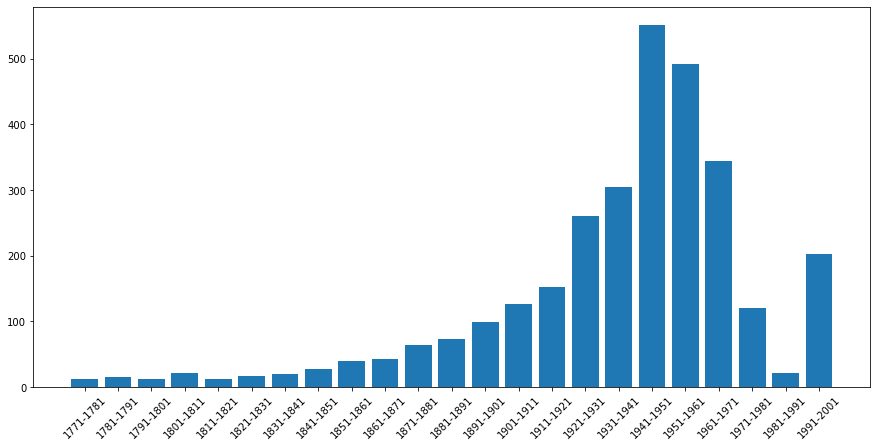

In [361]:
### Distribution des naissances par décennie

objects = [l for l in gb_decennie.index]
eff = [l for l in gb_decennie]

print(objects[:5])
plt.figure(figsize=(15,7))
plt.xticks(rotation=45)
plt.bar(objects, eff)